# Insurance Claims and Policy Data Analysis

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import scipy.stats as stats
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

Setting the plotting style

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

Loading the dataset(s)

In [ ]:
insurance_df = pd.read_csv('./data/insurance_dataset.csv')
synthetic_df = pd.read_csv('./data/data_synthetic.csv')

Getting some basic information about the datasets

In [4]:
print("Insurance Dataset Info: ")
print(insurance_df.info())
print("\nSynthetic Dataset Info: ")
print(synthetic_df.info())

Insurance Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             13000 non-null  float64
 1   Gender          13000 non-null  object 
 2   Income          13000 non-null  float64
 3   Marital_Status  13000 non-null  object 
 4   Education       13000 non-null  object 
 5   Occupation      13000 non-null  object 
 6   Claim_Amount    13000 non-null  float64
dtypes: float64(3), object(4)
memory usage: 711.1+ KB
None

Synthetic Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53503 entries, 0 to 53502
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Customer ID                         53503 non-null  int64 
 1   Age                                 53503 non-null  int64 
 2   Gender 

Displaying the first few rows of the dataset

In [5]:
print("First 5 rows of the Insurance Dataset")
display(insurance_df.head())

First 5 rows of the Insurance Dataset


,Age,Gender,Income,Marital_Status,Education,Occupation,Claim_Amount
0,59.0,Male,270727.0,Single,Master's,Doctor,3455.0
1,21.0,Female,263874.0,Single,Bachelor's,Engineer,30233.0
2,71.0,Female,48372.0,Single,Bachelor's,Engineer,340.0
3,30.0,Female,99525.0,Single,PhD,CEO,1002.0
4,64.0,Female,187038.0,Married,Master's,CEO,2828.0


In [6]:
print("First 5 rows of the Synthetic Dataset")

display(synthetic_df.head())

First 5 rows of the Synthetic Dataset


,Customer ID,Age,Gender,Marital Status,Occupation,Income Level,Education Level,Geographic Information,Location,Behavioral Data,...,Customer Preferences,Preferred Communication Channel,Preferred Contact Time,Preferred Language,Risk Profile,Previous Claims History,Credit Score,Driving Record,Life Events,Segmentation Group
0,84966,23,Female,Married,Entrepreneur,70541,Associate Degree,Mizoram,37534,policy5,...,Email,In-Person Meeting,Afternoon,English,1,3,728,DUI,Job Change,Segment5
1,95568,26,Male,Widowed,Manager,54168,Doctorate,Goa,63304,policy5,...,Mail,In-Person Meeting,Morning,French,1,2,792,Clean,Retirement,Segment5
2,10544,29,Female,Single,Entrepreneur,73899,Associate Degree,Rajasthan,53174,policy5,...,Email,Mail,Evening,German,2,1,719,Accident,Childbirth,Segment3
3,77033,20,Male,Divorced,Entrepreneur,63381,Bachelor's Degree,Sikkim,22803,policy5,...,Text,In-Person Meeting,Anytime,French,3,0,639,DUI,Job Change,Segment3
4,88160,25,Female,Separated,Manager,38794,Bachelor's Degree,West Bengal,92858,policy1,...,Email,Text,Weekends,English,0,3,720,Major Violations,Childbirth,Segment2


*NOTE*

The two files do not have a common column upon which they can be merged. For the purpose of this analysis, I will be focusing on the _Insurance Dataset_.

Checking for missing values in the dataset.

In [7]:
print("Missing values in the dataset")
print(insurance_df.isnull().sum())

Missing values in the dataset
Age               0
Gender            0
Income            0
Marital_Status    0
Education         0
Occupation        0
Claim_Amount      0
dtype: int64


The dataset appears to be complete, with no missing values.

Exploring the basic statistics for the numerical columns

In [8]:
print("Basic Statistics for the dataset")
display(insurance_df.describe())

Basic Statistics for the dataset


,Age,Income,Claim_Amount
count,13000.000000,13000.000000,13000.000000
mean,51.530308,161718.427413,9185.646615
std,20.965770,99965.550464,15041.942150
min,18.000000,5091.000000,114.000000
25%,34.000000,75080.750000,3344.750000
50%,51.000000,154855.500000,5829.500000
75%,67.000000,235395.250000,8293.250000
max,102.421544,404427.908255,99841.000000


Takeaways:

* Age is ~ *normally distributed*, centered around 50 years, with most observations (≈68%) falling between **31 and 73 years**. The distribution appears balanced (median ≈ mean), suggesting minimal skewness, making age relatively stable and predictable compared to the other variables.

* Income exhibits **substantial variability**, with the standard deviation representing over **60% of the mean**. The quartiles show that 50% of individuals earn between ~$75k and ~$235k. The mean is higher than the median (~155k), indicating a **right-skewed distribution** driven by higher-income individuals. For this skewness, it might be necessary to apply various transformations, and this may help stabilize variance in subsequent analyses.


* Claim amounts are **highly variable** as the standard deviation exceeds the mean, reflecting a distribution dominated by a small proportion of very large claims. The median claim (~$5,829) is significantly lower than the mean, confirming **right-skewness**. This pattern is typical in insurance data, where the majority of claims are modest, but rare, high-cost claims exert a disproportionate impact. Modeling claim amounts may therefore require non-normal distributions (e.g., Gamma, Lognormal, or Tweedie) or the use of quantile-based methods.


More on these later, let us proceed to explore the basic statistics for the categorical columns.


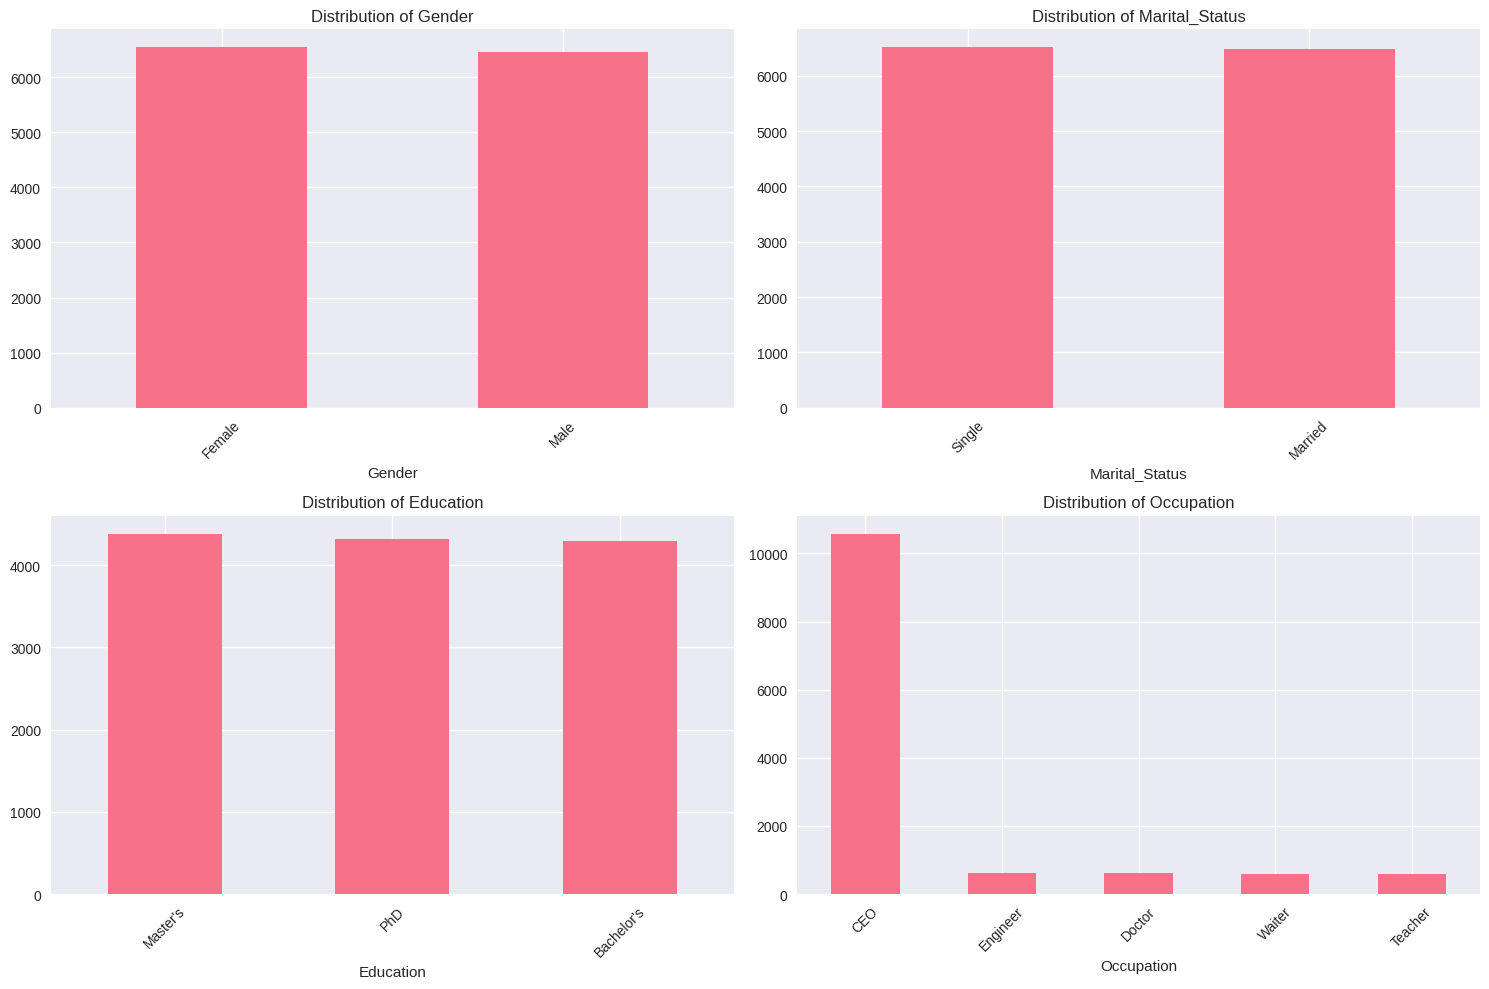

In [9]:
categorical_cols = ["Gender", "Marital_Status", "Education", "Occupation"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    insurance_df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Takeaways.

* *Gender*, *Marital Status*, and *Education* are quite evenly distributed, with no single category dominating the other. These variables cause no huge imbalance in the dataset as all the groups in each category are well represented.

* Occupation variable is *highly imbalanced*, as the CEOs dominate the dataset (>10,000 out of a dataset of 13,000 records). Other occupations, incl. engineer, doctor, waiter, teacher, etc. have a few hundred observations

The categorical imbalance in the _Occupation_ column creates an imbalance, which possibly contributes to the right-skewness of the _income_ and _claims_ variables.

*Generating a Skewness Summary for the Numeric Columns*

In [11]:
insurance_df.skew(numeric_only=True)

Age             0.437886
Income          0.489319
Claim_Amount    4.060901
dtype: float64

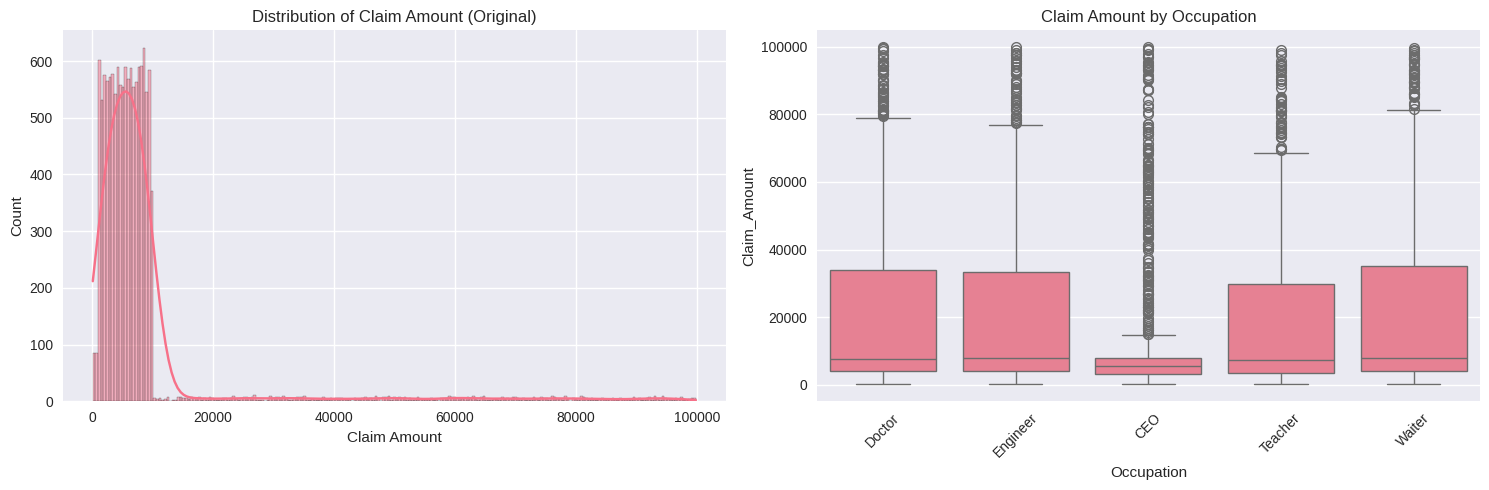

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(insurance_df['Claim_Amount'], kde=True)
plt.title('Distribution of Claim Amount (Original)')
plt.xlabel('Claim Amount')

plt.subplot(1, 2, 2)
sns.boxplot(x="Occupation", y="Claim_Amount", data=insurance_df)
plt.title('Claim Amount by Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Takeaways:

* Age and Income are low/approximately symmetric, so we can treate this as approximately normal.
* Claim Amount is extremely right skewed, and will require transformation later on.

References: [DataCamp - Understanding Skewness and Kurtosis](https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis)

# Exploratory Data Analysis

## Correlation Analysis

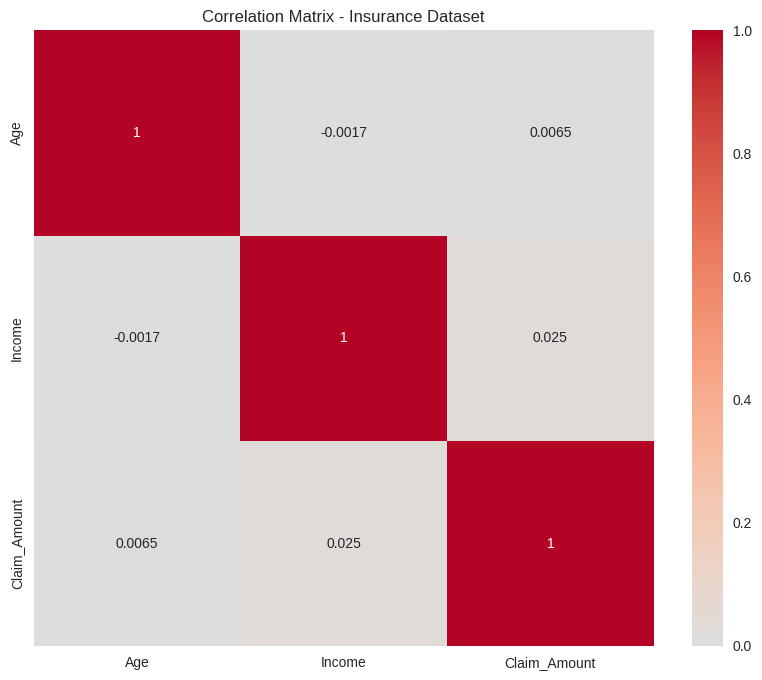

In [15]:
plt.figure(figsize=(10, 8))
corr_matrix = insurance_df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Insurance Dataset')
plt.show()

## Relationship Between Age and Claim Amount

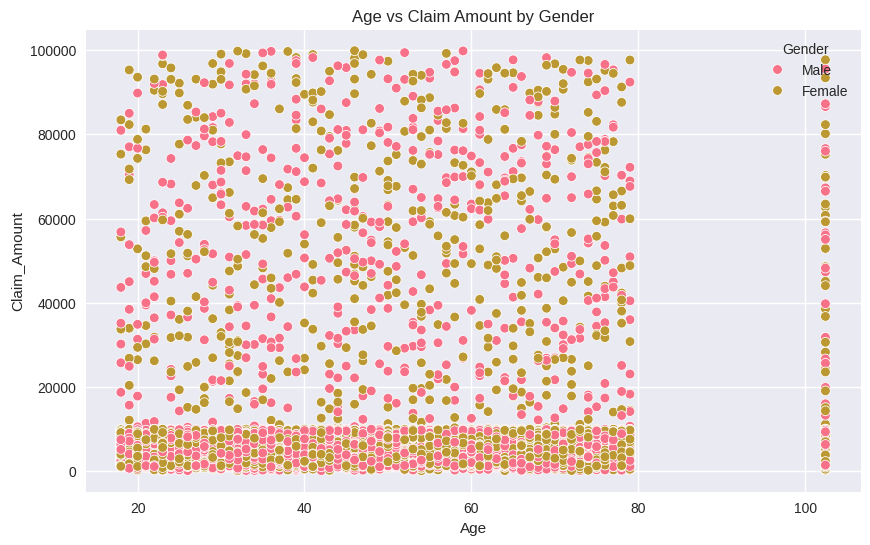

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Claim_Amount', hue='Gender', data=insurance_df)
plt.title('Age vs Claim Amount by Gender')
plt.show()

## Relationship between Income and Claim Amount

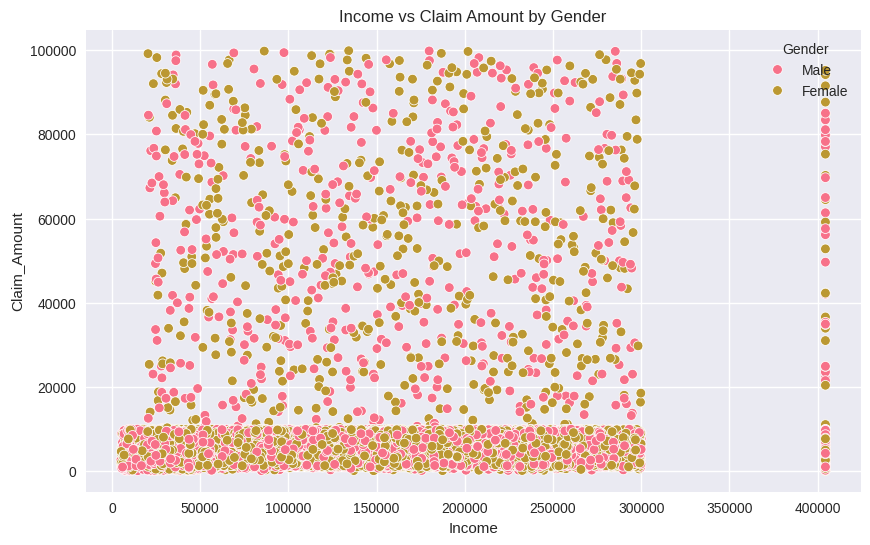

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='Claim_Amount', hue='Gender', data=insurance_df)
plt.title('Income vs Claim Amount by Gender')
plt.show()

## Boxplot of Claim Amount by Occupation

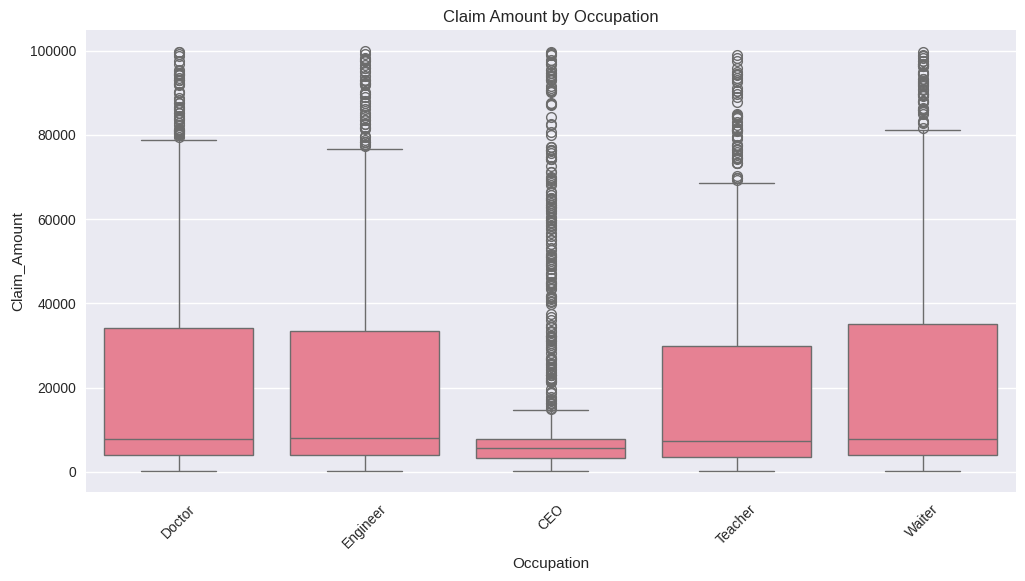

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Occupation', y='Claim_Amount', data=insurance_df)
plt.title('Claim Amount by Occupation')
plt.xticks(rotation=45)
plt.show()

## Boxplot of Claim Amount by Education Level

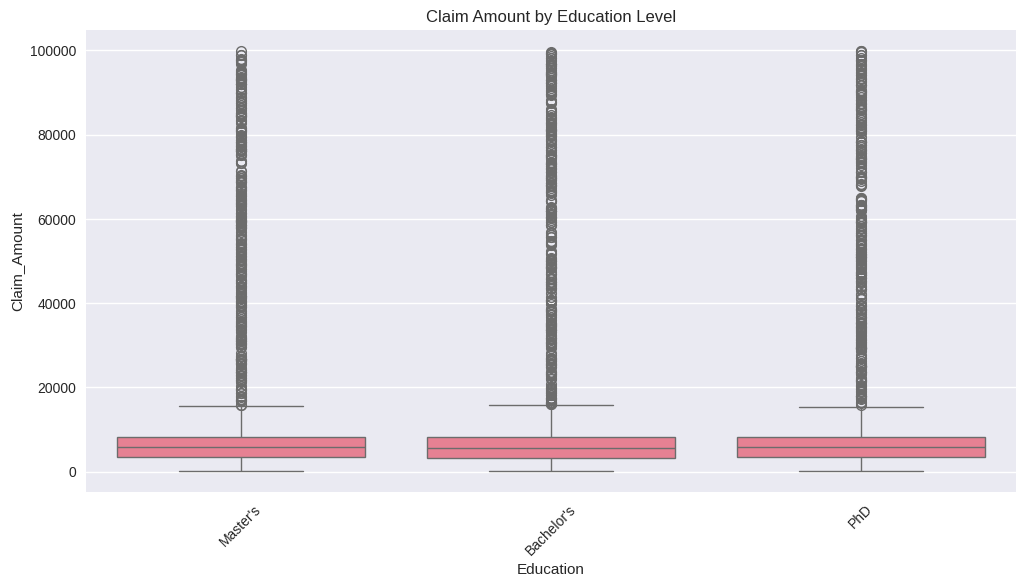

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Education', y='Claim_Amount', data=insurance_df)
plt.title('Claim Amount by Education Level')
plt.xticks(rotation=45)
plt.show()

# Transformations

This step will involve applying a log transformation to the `Claim Amount` variable, as the column has is positively skewed. 

* Reference: [Anatomise BioStats - Transforming skewed data](https://anatomisebiostats.com/biostatistics-blog/transforming-skewed-data/)

In [20]:
insurance_df["Log_Claim_Amount"] = np.log1p(insurance_df["Claim_Amount"])
print(f"Log Transformed Skewness: {insurance_df['Log_Claim_Amount'].skew()}")

Log Transformed Skewness: 0.5524178864678371


This transformation reduced our skewness from *4.06* to *0.55*, which is moderately skewed and oftenly accepted in practice.

References

* [National Institute of Standards and Technology](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm).
* [Omega Graduate School - How to Conduct Normality Tests using PSPP in Statistics for Social Research](https://ogs.edu/how-to-conduct-normality-tests-using-pspp-in-statistics-for-social-research/).

### Visualizing the Transformation

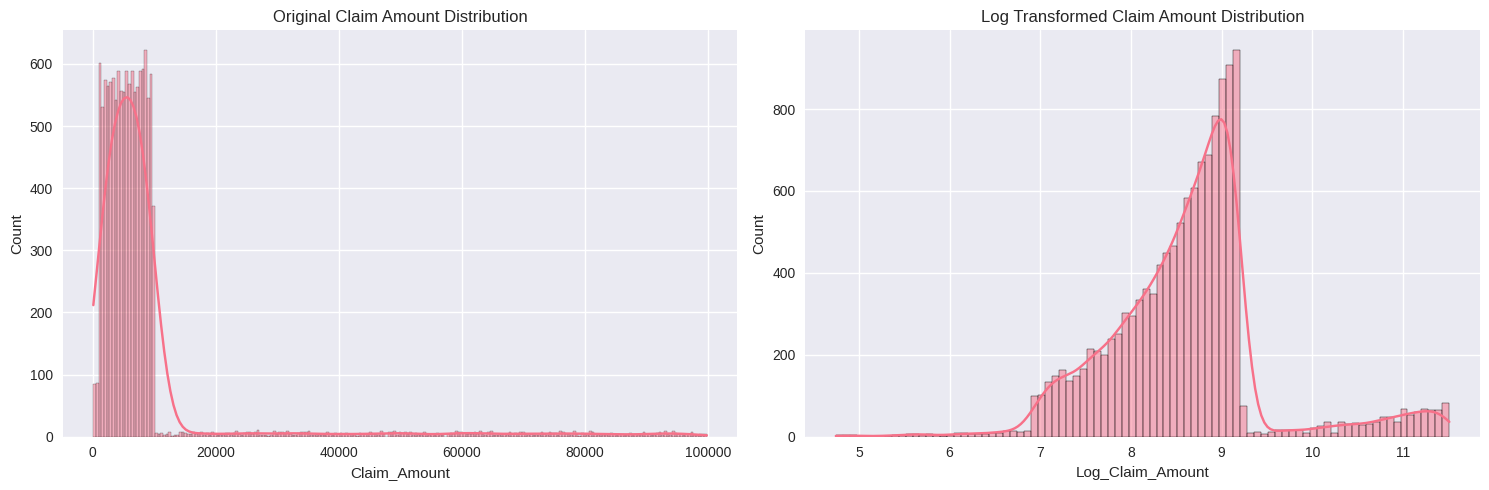

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(insurance_df['Claim_Amount'], kde=True, ax=axes[0])
axes[0].set_title('Original Claim Amount Distribution')
sns.histplot(insurance_df['Log_Claim_Amount'], kde=True, ax=axes[1])
axes[1].set_title('Log Transformed Claim Amount Distribution')
plt.tight_layout()
plt.savefig('claim_distribution.png')
plt.show()

Is this new and transformed claim amount dataset now normal? What other methods can I employ to ensure the skewness follows a bell-shaped normal distribution? Options include exploring other transformations, including *Box-Cox* or *Yeo-Johnson*, but to keep things simple, let the current *Natural Log* transformation work.

## Occupation Analysis

In [22]:
occupation_stats = insurance_df.groupby('Occupation').agg({
    'Claim_Amount': ['count', 'mean', 'median', 'std'],
    'Income': 'mean'
}).round(2)
occupation_stats.columns = ['Count', 'Mean_Claim', 'Median_Claim', 'Std_Claim', 'Mean_Income']
occupation_stats = occupation_stats.sort_values('Mean_Claim', ascending=False)
print("\nOccupation Statistics:")
print(occupation_stats)


Occupation Statistics:
            Count  Mean_Claim  Median_Claim  Std_Claim  Mean_Income
Occupation                                                         
Waiter        587    22761.66        7879.0   29042.50    136954.75
Doctor        624    22040.64        7730.5   28106.85    125737.43
Engineer      633    21685.85        7997.0   27739.65    134746.48
Teacher       581    20251.78        7214.0   26348.89    123606.77
CEO         10575     6317.31        5592.0    7516.19    168924.53


### Correlation Analysis

Running an updated correlation analysis

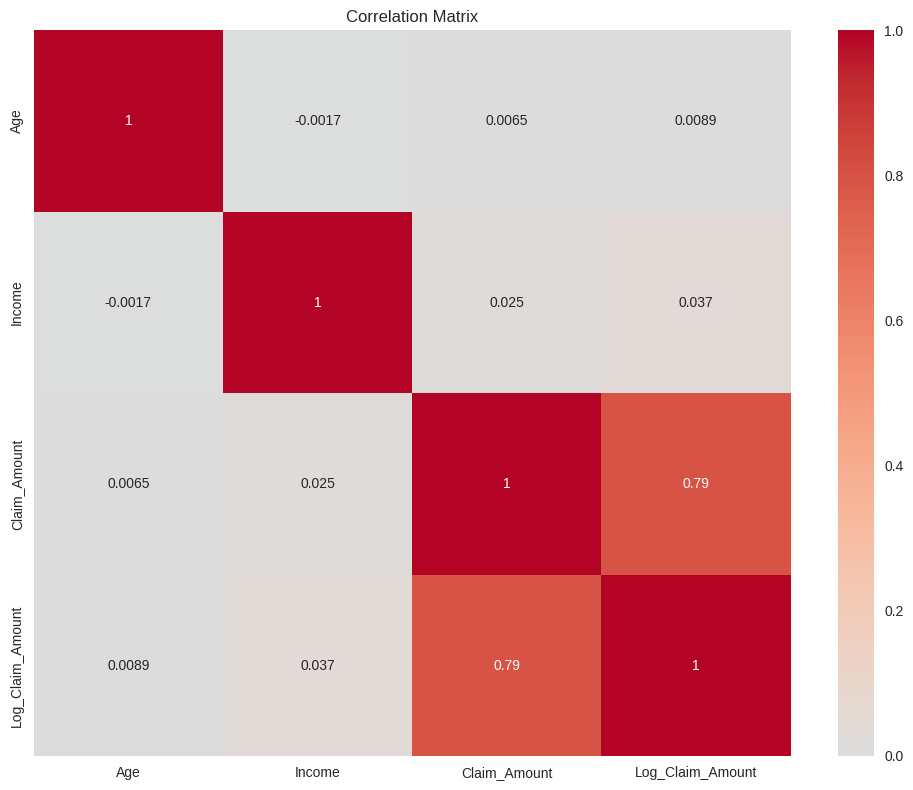

In [23]:
plt.figure(figsize=(10, 8))
numeric_df = insurance_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

In [24]:
correlation_matrix

,Age,Income,Claim_Amount,Log_Claim_Amount
Age,1.000000,-0.001650,0.006490,0.008944
Income,-0.001650,1.000000,0.024806,0.036678
Claim_Amount,0.006490,0.024806,1.000000,0.791632
Log_Claim_Amount,0.008944,0.036678,0.791632,1.000000


The correlation values are still low, meaning that there is almost no linear relationship between *Log Claim Amount* and *Age and Income*.

## Preparing Data For Modelling

In [25]:
X = insurance_df.drop(['Claim_Amount', 'Log_Claim_Amount'], axis=1)
y = insurance_df['Log_Claim_Amount']

Identifying feature types

In [26]:
numeric_features = ['Age', 'Income']
categorical_features = ['Gender', 'Marital_Status', 'Education', 'Occupation']

Creating a preprocessing pipeline for:

* Numeric transformation.
* Categorical transformation.

In [29]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Splitting the dataset into training and testing sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Modelling.

### Defining the models to evaluate

We will be applying the following models:

* Linear Regression.
* Ridge Regression.
* Lasso Regression.
* Random Forest Regression.
* Gradient Boosting Regression.

In [31]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

Evaluating the models

In [32]:
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Cross Validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, 
                               scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    results[name] = {
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std()
    }
    
    print(f"{name}: Mean RMSE = {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")

Linear Regression: Mean RMSE = 0.8564 (±0.0190)
Ridge: Mean RMSE = 0.8564 (±0.0190)
Lasso: Mean RMSE = 0.8906 (±0.0199)
Random Forest: Mean RMSE = 0.8866 (±0.0087)
Gradient Boosting: Mean RMSE = 0.8375 (±0.0139)


Finding the best model

In [33]:
best_model_name = min(results, key=lambda x: results[x]['RMSE_mean'])
print(f"\nBest model: {best_model_name}")


Best model: Gradient Boosting


Training the best model on the full training data

In [34]:
best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Making predictions in the log space, and then converting these predictions back to the original scale

In [35]:
# Making predictions in the log space
y_pred_log = pipeline.predict(X_test)

# Converting predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)


Calculating the evaluation metrics

In [36]:
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)

In [37]:
print(f"\nPerformance on test dataset:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Performance on test dataset:
RMSE: 14811.97
R²: 0.0864
MAE: 5973.38


Residual analysis

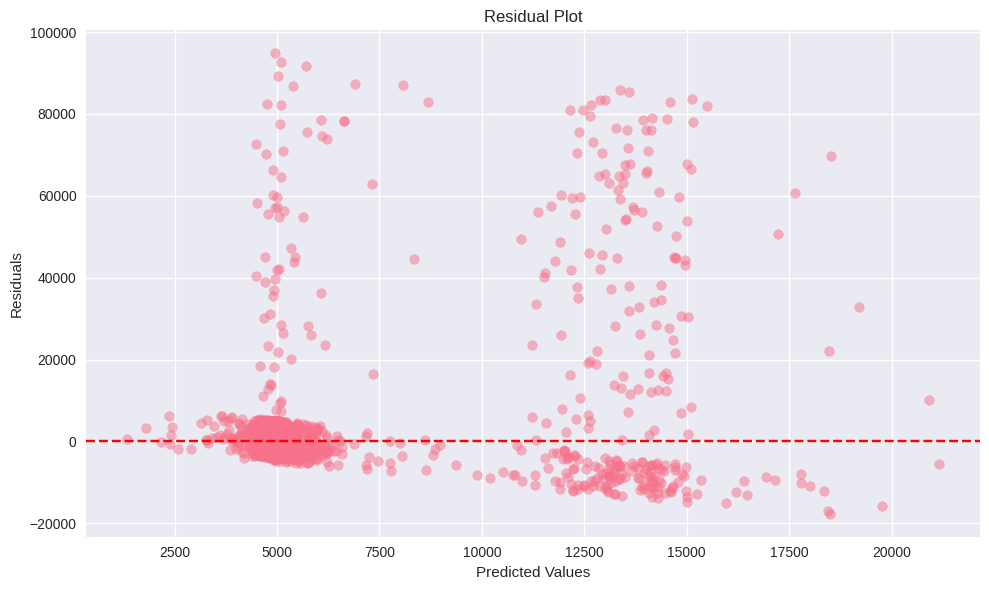

In [38]:
residuals = y_test_orig - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()

Feature Importance

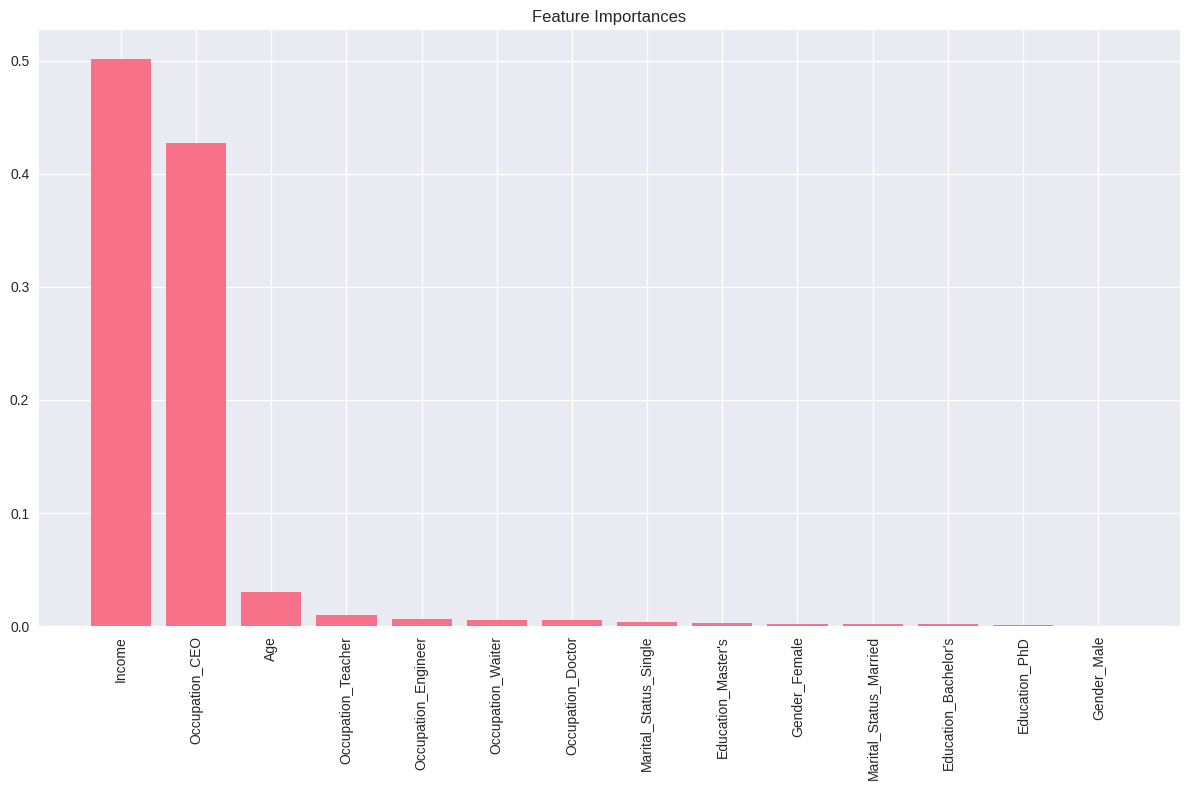

In [39]:
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after one-hot encoding
    preprocessor.fit(X)
    feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
    
    # Get feature importances
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

## Underwiting Strategy Optimization

### Calculating risk scores based on the predicted claim amounts

In [40]:
risk_scores = pipeline.predict(X)
insurance_df['Predicted_Claim_Amount'] = np.expm1(risk_scores)
insurance_df['Risk_Score'] = (insurance_df['Predicted_Claim_Amount'] - 
                             insurance_df['Predicted_Claim_Amount'].min()) / \
                             (insurance_df['Predicted_Claim_Amount'].max() - 
                              insurance_df['Predicted_Claim_Amount'].min())

Defining the function for premium calculation

In [41]:
def calculate_premium(base_premium, risk_score, profit_margin=0.2):
    """Calculate premium based on risk score"""
    risk_adjustment = 1 + risk_score  # Higher risk = higher premium
    return base_premium * risk_adjustment * (1 + profit_margin)

Now, proceeding to an example of premium calculation

In [ ]:

base_premium = 1000  # (Base premium amount)
insurance_df['Recommended_Premium'] = insurance_df['Risk_Score'].apply(
    lambda x: calculate_premium(base_premium, x)
)

In [43]:
print("\nUnderwriting Strategy Summary:")
print(f"Average Risk Score: {insurance_df['Risk_Score'].mean():.4f}")
print(f"Average Recommended Premium: ${insurance_df['Recommended_Premium'].mean():.2f}")


Underwriting Strategy Summary:
Average Risk Score: 0.1472
Average Recommended Premium: $1376.68


## Saving the Model for Deployment

In [46]:
import pickle

with open('insurance_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("\nModel saved as insurance_model.pkl")


Model saved as insurance_model.pkl
